In [1]:
import faultdiagnosistoolbox as fdt
import sympy as sym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

## Parameter sensitivity analysis

In [3]:
df_nf = pd.read_csv('data/nf_ex1.csv', sep=';', index_col=0)
df_f1 = pd.read_csv('data/f1_ex1.csv', sep=';', index_col=0)
df_f2 = pd.read_csv('data/f2_ex1.csv', sep=';', index_col=0)

In [4]:
def get_model(a, b, c, d, e):
    modeldef = {
        "type": "Symbolic",
        "x": ["x1", "x2", "x3", "dx1", "dx2", "dx3"],
        "f": ["f1", "f2"],
        "z": ["y1", "y3", "u"]
    }

    sym.var(modeldef["x"])
    sym.var(modeldef["f"])
    sym.var(modeldef["z"])

    modeldef["rels"] = [
        -dx1 -a * x1 - b * x2 + c * u + f1,
        -dx2 -0.2 * x2 + 0.1 * x1 - 0.1 * x3 + f2,
        -dx3 - d * x3 + e * x2,
        -y1 + x1,
        -y3 + x3,
        fdt.DiffConstraint("dx1", "x1"),
        fdt.DiffConstraint("dx2", "x2"),
        fdt.DiffConstraint("dx3", "x3")
    ]
    return fdt.DiagnosisModel(modeldef, name="")

In [5]:
def compute_residual(dat, ResGen):
    r = np.zeros(len(dat)) # N number of data points
    state = {'x1': 0, 'x2': 0, 'x3': 0}
    z = dat[['x1', 'x3', 'u']]
    x1s = []
    x3s = []
    for k, zk in enumerate(z.itertuples()):
        r[k], state = ResGen(zk[1:], state, None, 1)
        x1s.append(state['x1'])
        x3s.append(state['x3'])
    return x1s, r

In [6]:
a0, b0, c0, d0, e0 = 0.2, 0.1, 1, 0.2, 0.1

In [7]:
def build_res_gen(model, name='ResGen1_test'):
    msos = model.MSO()
    M1 = msos[1]
    r = 3
    M0 = [e for e in M1 if e != r]
    Gamma =model.Matching(M0)
    model.SeqResGen(Gamma, r, name)

In [8]:
mult = [i/10 for i in range(6, 15)]

In [9]:
r_ma = []
r_ma_f1 =[]
for m in mult:
    model = get_model(a0, b0, c0, d0, m * e0)
    build_res_gen(model, name='Res')
    exec(open('Res.py').read())
    x1s, r = compute_residual(df_f2, Res)
    x1s_f1, r_f1 = compute_residual(df_f1, Res)
    r_ma.append((np.abs(r[:100]).mean(), np.abs(r[100:]).mean()))
    r_ma_f1.append(np.abs(r_f1[100:]).mean())

Generating residual generator Res (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  Writing residual generator file
File Res.py generated.
Generating residual generator Res (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  Writing residual generator file
File Res.py generated.
Generating residual generator Res (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  Writing residual generator file
File Res.py generated.
Generating residual generator Res (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  Writing residual generator file
File Res.py generated.
Generating residual generator Res (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  

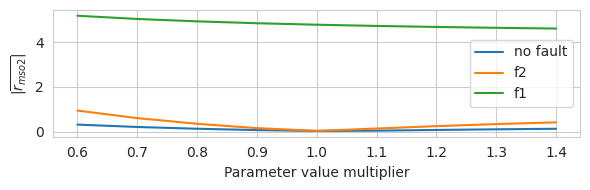

In [10]:
tmp = list(zip(*r_ma))
r_ma_nf, r_ma_f2 = tmp[0], tmp[1]
plt.figure(figsize=(6, 2))
plt.plot(mult, r_ma_nf, label='no fault');
plt.plot(mult, r_ma_f2, label='f2');
plt.plot(mult, r_ma_f1, label='f1');
plt.legend()
plt.xlabel('Parameter value multiplier');
plt.ylabel('$|\overline{r_{mso2}}|$');
plt.tight_layout()
plt.savefig('pic/param_sensitivity_ex1.pdf', dpi=300, bbox_inches='tight')
plt.show()